# Auto Assignning the tickets to assignement group using machine learning models and its  Impact on MTTR/MTTF

## Install necessary libraries

In [180]:
# !pip install wordcloud

## Importing the libraries

In [181]:
#import all necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset consists of 684 records and 15 columns. Below is a summary of the key characteristics:

Data Completeness: The dataset is mostly complete, with only a few missing values in columns like category, location, assigned_to, and reassignment_count.

Data Types:
1. Categorical Columns (Object Type):
* category: The type of issue reported (e.g., Software, Hardware).
* state: The current status of the incident (e.g., Closed, Resolved).
* closed_by, number, sys_updated_by, caller_id, assignment_group, priority: Various identifiers and descriptive fields relevant to the incident.
* location: The physical or virtual location associated with the incident.
* assigned_to: The individual or group responsible for resolving the incident.
* predicted_by_model: Whether the assignment group predicted by model or filled up manually.

2. Numeric Columns:
* reassignment_count: The number of times the incident was reassigned (floating point).

3. Date and Time Columns:
* closed_at, opened_at, sys_updated_on: These fields represent key timestamps in the lifecycle of the incident, important for calculating metrics like Mean  Time to Resolution (MTTR)/ Mean Time to Fulfillment (MTTF).

4. Text Columns:
* short_description

Key Observations:
1. Categorical Data: The dataset includes a variety of categorical data, which will be crucial for analyzing patterns in incident routing and resolution.
2. Time Data: The presence of opened_at, closed_at, and sys_updated_on allows for precise time-based analysis, such as tracking the duration of incidents and identifying delays.
3. Reassignment Count: The reassignment_count column is particularly important for this study, as it directly relates to the impact of manual routing on MTTR/MTTF.

## Importing the dataset

In [183]:
file_path = '/content/drive/MyDrive/dataset/incidents_v2.csv'
df = pd.read_csv(file_path)
# Display the first few rows of the dataset
# df.head(), df.info()

#1. Analysis of Manual Routing and its Impact on Mean Time to Resolution (MTTR) / Mean Time to Fulfillment (MTTF)

## Data Preparation

Calculate MTTR/MTTF: Calculated MTTR (Mean Time to Resolution) / MTTF (Mean Time to Fulfillment) for each ticket. MTTR/MTTF is typically calculated by subtracting the opened_at timestamp from the closed_at timestamp.

In [184]:
# Convert opened_at and closed_at to datetime
df['opened_at'] = pd.to_datetime(df['opened_at'])
df['closed_at'] = pd.to_datetime(df['closed_at'])

# Example mapping of priority levels to numerical values
priority_mapping = {
    '1 - Critical': 1,
    '2 - High': 2,
    '3 - Moderate': 3,
    '4 - Low': 4,
    '5 - Planning': 5
}

# Apply the mapping to the 'priority' column
df['priority_numeric'] = df['priority'].map(priority_mapping)

Data Aggregation: Aggregated the data to get average MTTR/MTTF values by following different factors
1. Reassignment Count
2. Assignment Group
3. Priority

In [185]:
# Calculate MTTR in hours
df['MTTR'] = (df['closed_at'] - df['opened_at']).dt.total_seconds() / 3600

df_1 = df.copy()
df_1.head()

df_1 = df_1[df_1['predicted_by_model'] == False]
print(df_1['MTTR'].mean())

# Group by reassignment count and calculate average MTTR
mttr_by_reassignment = df_1.groupby('reassignment_count')['MTTR'].mean()

# Group by assignment group and calculate average MTTR
mttr_by_group = df_1.groupby('assignment_group')['MTTR'].mean()

# Group by priority and calculate average MTTR
mttr_by_priority = df_1.groupby('priority')['MTTR'].mean()

print("Average MTTR/MTTF by Reassignment Count:")
print(mttr_by_reassignment)

print("\nAverage MTTR/MTTF by Assignment Group:")
print(mttr_by_group)

print("\nAverage MTTR/MTTF by Priority:")
print(mttr_by_priority)

350.6157359451085
Average MTTR/MTTF by Reassignment Count:
reassignment_count
0    122.279960
1    349.478352
2    329.191136
3    450.699548
4    293.807886
5    285.746893
6    286.071897
7    488.524541
Name: MTTR, dtype: float64

Average MTTR/MTTF by Assignment Group:
assignment_group
Database                     168.548582
Hadoop admin                  93.600833
Hardware                     174.397397
Major Incident Management    209.805833
Network                      387.071500
Openspace                    126.651111
Service Desk                 774.770774
Software                     183.779269
Name: MTTR, dtype: float64

Average MTTR/MTTF by Priority:
priority
1 - Critical    510.999208
2 - High        305.210561
3 - Moderate    177.787989
4 - Low         225.972639
5 - Planning    175.986920
Name: MTTR, dtype: float64


Text Cleaning

* Lowercasing: Convert all text to lowercase to ensure consistency, as "Error" and "error" would otherwise be treated as different words.
* Removing Punctuation and Special Characters: Strip out punctuation marks, numbers, and other special characters that don't add meaningful information.
* Removing Stopwords: Remove common stop words like "the", "and", "is", etc., that do not contribute to the meaning of the text.


In [186]:
# Function to clean and preprocess the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

# Apply the cleaning function to the short_description column
df_1['short_description_cleaned'] = df_1['short_description'].apply(clean_text)

# Generate a word frequency analysis
word_counts = Counter(" ".join(df_1['short_description_cleaned']).split())

# Get the 20 most common words
common_words = word_counts.most_common(20)

* Tokenization Split the text into individual words or tokens. For example, the sentence "Printer is not working" would be split into ["printer", "not", "working"].
* TF-IDF (Term Frequency-Inverse Document Frequency): Convert the cleaned and tokenized text data into numerical features that represent the importance of each word relative to the entire dataset.
* The TfidfVectorizer converts the cleaned text data into numerical features. These features represent the importance of each word in the context of the dataset, making it easier to correlate text data with numerical outcomes like MTTR or reassignment counts.


In [187]:
# Tokenization is inherent in the TF-IDF process, so no need for explicit tokenization here

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to top 1000 words
tfidf_matrix = tfidf_vectorizer.fit_transform(df_1['short_description_cleaned'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

Combining Data:

The TF-IDF features are combined with the original dataset to perform further analysis, such as calculating correlations or building predictive models.

In [188]:
# Combine TF-IDF features with the original DataFrame for analysis
data_tfidf = pd.concat([df_1, tfidf_df], axis=1)

In [189]:
# Calculate the correlation between TF-IDF features and MTTR
# Filter out non-TFIDF columns such as 'MTTR', 'reassignment_count', etc.
text_features = tfidf_df.columns
# Ensure that only numeric columns are used for correlation
numeric_tfidf_features = data_tfidf[text_features].select_dtypes(include=[np.number])

# Calculate the correlation between TF-IDF features and MTTR
correlation_tfidf_mttr = numeric_tfidf_features.corrwith(data_tfidf['MTTR']).sort_values(ascending=False).head(10)

# Calculate the correlation between TF-IDF features and reassignment count
correlation_tfidf_reassignment = numeric_tfidf_features.corrwith(data_tfidf['reassignment_count']).sort_values(ascending=False).head(10)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Statistical Analysis

Correlation Analysis: The correlation between reassignment count and MTTR/MTTF is 0.05072(approximately 0.051), indicating a moderate weak relationship. The correlation of 0.051 between reassignment count and MTTR suggests that reassignment count alone is not a strong predictor of resolution time in this dataset. However, it remains an important metric to monitor, especially in conjunction with other variables that may better explain changes in MTTR.


In [190]:
# Calculate the correlation between reassignment count and MTTR/MTTF
correlation_value = df_1['reassignment_count'].corr(df_1['MTTR'])
print(f"Correlation between Reassignment Count and MTTR: {correlation_value}")

# Calculate the correlation between reassignment count and MTTR/MTTF
correlation_value = df_1['priority_numeric'].corr(df_1['MTTR'])
print(f"Correlation between Priority and MTTR: {correlation_value}")


Correlation between Reassignment Count and MTTR: 0.05072791197430779
Correlation between Priority and MTTR: -0.22744917162848372


Average MTTR by Reassignment Count: The average MTTR (approx) based on the number of times a ticket was reassigned is as follows:
* 0 Reassignments: 285.66 hours
* 1 Reassignment: 356.03 hours
* 2 Reassignments: 342.57 hours
* 3 Reassignments: 614.74 hours
* 4 Reassignments: 273.75 hours
* 5 Reassignments: 681.28 hours
* 6 Reassignments: 434.09 hours
* 7 Reassignments: 1307.03 hours


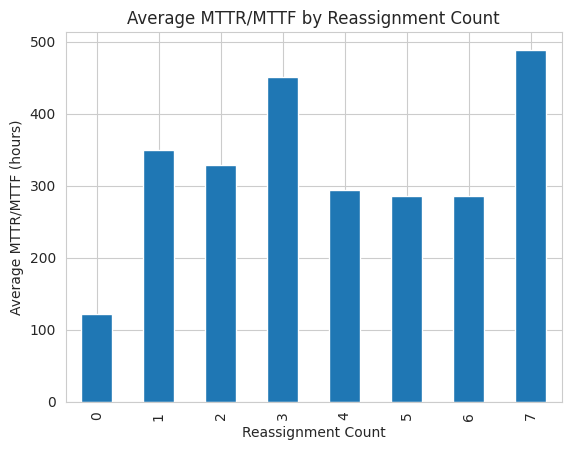

In [191]:
mttr_by_reassignment.plot(kind='bar')
plt.title('Average MTTR/MTTF by Reassignment Count')
plt.xlabel('Reassignment Count')
plt.ylabel('Average MTTR/MTTF (hours)')
plt.show()

Average MTTR/MTTF by Assignment Group: The average MTTR/MTTF (approx) for each assignment group is as follows:
* Database: 165.39 hours
* Hadoop admin: 93.60 hours
* Hardware: 175.78 hours
* Major Incident Management: 209.81 hours
* Network: 378.20 hours
* Openspace: 126.65 hours
* Service Desk: 796.74 hours
* Software: 168.30 hours


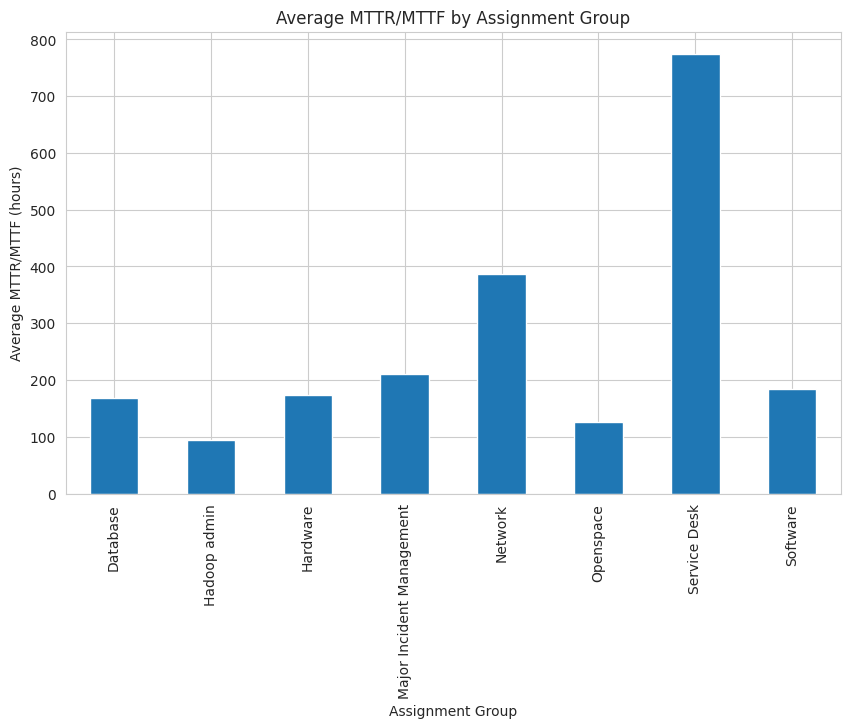

In [192]:
# Bar Plot for Average MTTR/MTTF by Assignment Group
plt.figure(figsize=(10, 6))
mttr_by_group.plot(kind='bar')
plt.title('Average MTTR/MTTF by Assignment Group')
plt.xlabel('Assignment Group')
plt.ylabel('Average MTTR/MTTF (hours)')
plt.show()

Average MTTR/MTTF by Priority: : The average MTTR/MTTF (approx) by priority level is as follows:
* 1 - Critical: 492.11 hours
* 2 - High: 290.96 hours
* 3 - Moderate: 178.05 hours
* 4 - Low: 243.99 hours
* 5 - Planning: 172.94 hours


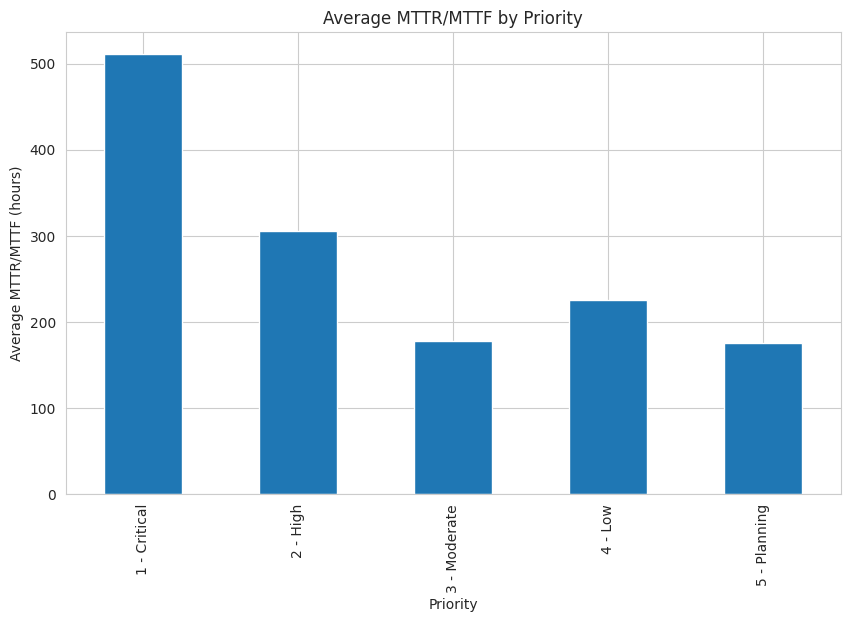

In [193]:
# Bar Plot for Average MTTR/MTTF by Priority
plt.figure(figsize=(10, 6))
mttr_by_priority.plot(kind='bar')
plt.title('Average MTTR/MTTF by Priority')
plt.xlabel('Priority')
plt.ylabel('Average MTTR/MTTF (hours)')
plt.show()

Group-wise Comparison: The average MTTR/MTTF varies significantly across assignment groups and priority levels, with Service Desk and high-priority incidents having notably higher MTTR/MTTF.

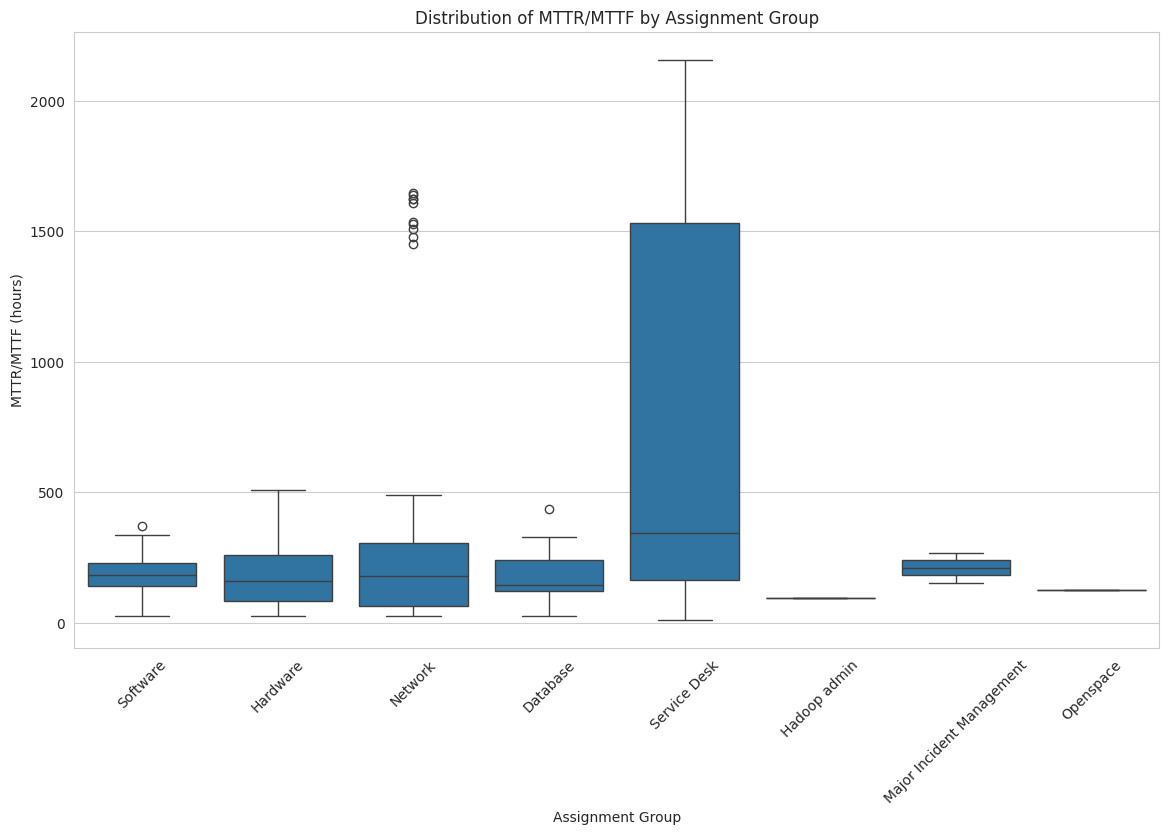

In [194]:
# Box Plot for Distribution of MTTR/MTTF by Assignment Group
plt.figure(figsize=(14, 8))
sns.boxplot(x='assignment_group', y='MTTR', data=df_1)
plt.title('Distribution of MTTR/MTTF by Assignment Group')
plt.xlabel('Assignment Group')
plt.ylabel('MTTR/MTTF (hours)')
plt.xticks(rotation=45)
plt.show()

##  Text Analysis of ‘short_description’

Word Cloud
* The Word Cloud displayed as follows illustrates the most frequently occurring terms in the short_description field. Larger words indicate higher frequency, revealing the most common types of issues reported. The Word Cloud indicates that incidents related to "printer", "email", "server", and "software" are predominant in the dataset.
* This visualization helps us understand the prevalent themes and common problems that IT teams are facing. The prominence of words like "printer", "email", and "server" suggests recurring technical issues in these areas, which may warrant closer attention to prevent frequent service disruptions.


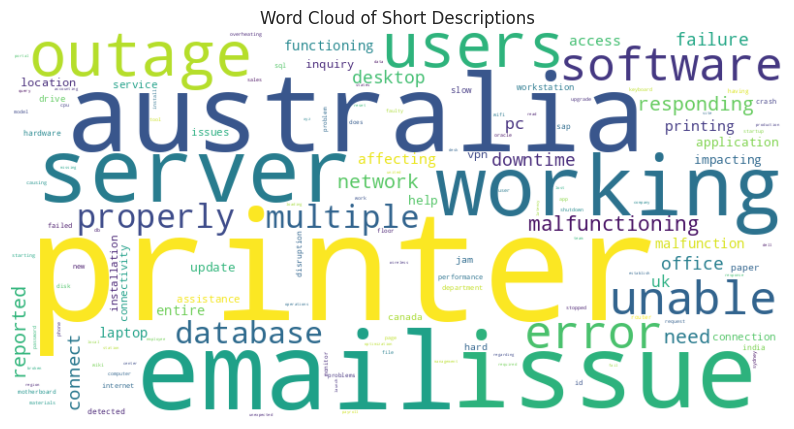

In [195]:
# Create a word cloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the Word Cloud Visualization
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Short Descriptions")
plt.show()

Word Correlation with MTTR/MTTF
* To understand the relationship between specific incident descriptions and the time taken to resolve them, we calculated the correlation between the most frequent words in the short_description and MTTR/MTTF. Below given figure shows the top 10 words that have the strongest positive correlation with MTTR/MTTF.
* The results indicate that incidents involving terms such as "email", "users", and "multiple" tend to have higher MTTR/MTTF. This suggests that issues affecting multiple users or involving email systems may be more complex, requiring more time to diagnose and resolve. These findings emphasize the need for more efficient processes or dedicated resources to handle these types of incidents.


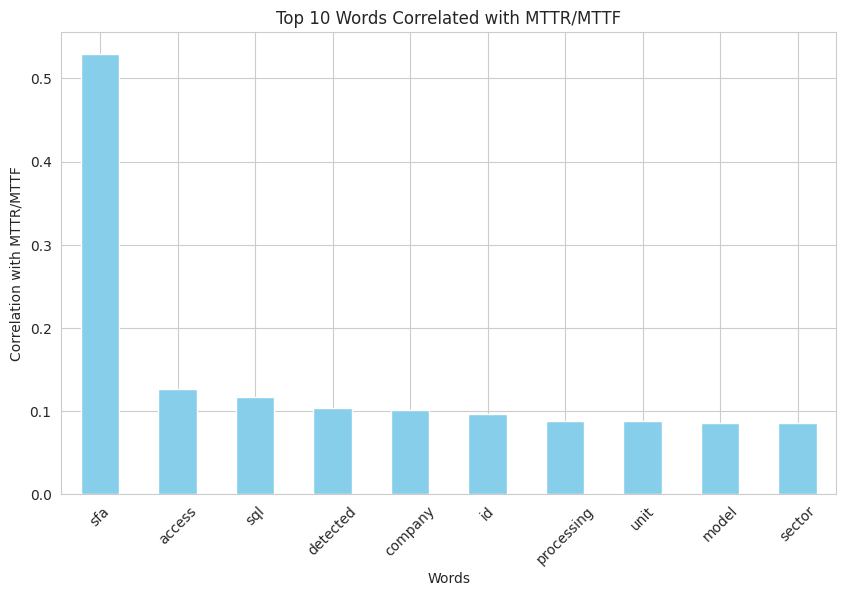

In [196]:
# Bar Plot for Word Correlation with MTTR/MTTF
plt.figure(figsize=(10, 6))
correlation_tfidf_mttr.plot(kind='bar', color='skyblue')
plt.title('Top 10 Words Correlated with MTTR/MTTF')
plt.xlabel('Words')
plt.ylabel('Correlation with MTTR/MTTF')
plt.xticks(rotation=45)
plt.show()

Word Correlation with Reassignment Count
* In addition to MTTR/MTTF, we also analyzed the correlation between specific words in the short_description and the reassignment count. Below given figure presents the top 10 words most strongly associated with higher reassignment counts.
* The analysis shows that incidents involving terms like "email" and "users" also tend to be reassigned more frequently. This may indicate that these types of issues require input from multiple teams or specialized knowledge, leading to increased reassignment counts. The need for multiple reassignments could be contributing to delays in resolution, as indicated by the higher MTTR/MTTF for these incidents.


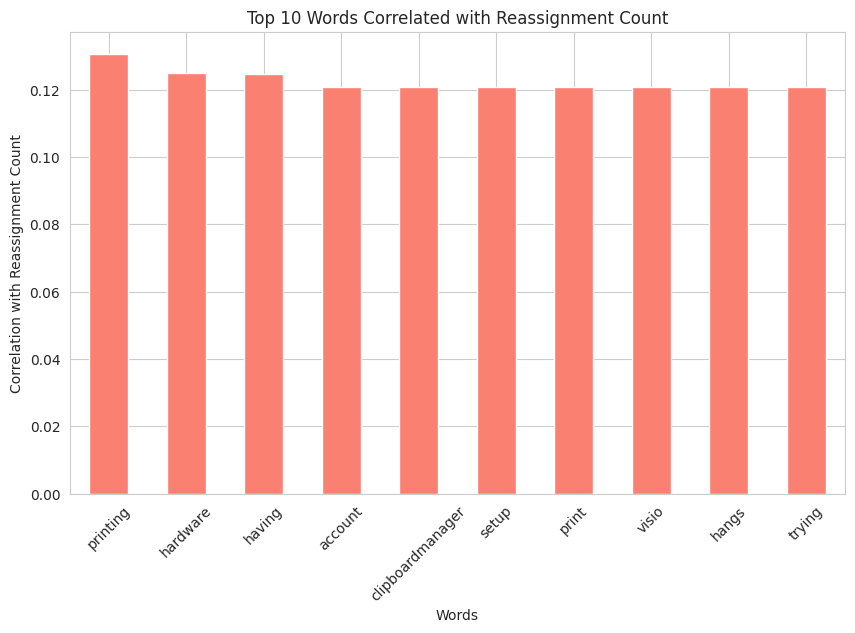

In [197]:
# Bar Plot for Word Correlation with Reassignment Count
plt.figure(figsize=(10, 6))
correlation_tfidf_reassignment.plot(kind='bar', color='salmon')
plt.title('Top 10 Words Correlated with Reassignment Count')
plt.xlabel('Words')
plt.ylabel('Correlation with Reassignment Count')
plt.xticks(rotation=45)
plt.show()

#2. Machine Learning Model Implementation and Evaluation

## Data Preprocessing

Load Dataset

In [198]:
df_2 = df.copy()

Text Cleaning & TF-IDF Vectorization

In [199]:
#drop nan rows
df_2 = df_2.dropna(subset=['assignment_group'])

In [200]:
# Apply the cleaning function to the short_description column
df_2['short_description_cleaned'] = df_2['short_description'].apply(clean_text)

In [201]:
# Preprocess the text data in 'short_description' using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = tfidf_vectorizer.fit_transform(df_2['short_description_cleaned'])

In [202]:
y = df_2['assignment_group']

Splitting the dataset into the Training set and Test set

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Logistic Regression Model Implementation

In [204]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

## Model Evaluation

In [205]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Print evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.8689320388349514
Precision: 0.8651072841899758
Recall: 0.8689320388349514
F1 Score: 0.8609998490620167
Confusion Matrix:
[[  8   0   4   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  0   0 105   0   1   2   0]
 [  0   0   0   0   0   1   0]
 [  0   0   3   0  19   7   0]
 [  0   0   4   0   1  40   0]
 [  1   0   0   0   0   2   7]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


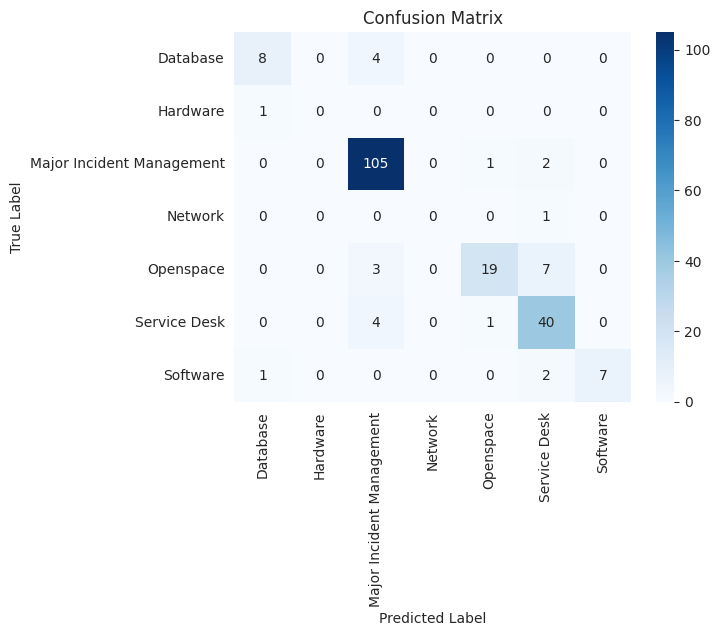

In [206]:
# Plot the confusion matrix

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# MTTR/MTTF with Model-Based Routing

## Impact of Model-Based Routing on MTTR/MTTF

In [211]:
# Create a new column to indicate whether routing was manual or model-based
df['routing_type'] = df['predicted_by_model'].apply(lambda x: 'Model-Based' if x else 'Manual')

# # Scatter plot showing the relationship between reassignment count and MTTR/MTTF
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='reassignment_count', y='MTTR', hue='routing_type')
# plt.title('Relationship between Reassignment Count and MTTR/MTTF')
# plt.xlabel('Reassignment Count')
# plt.ylabel('MTTR/MTTF (Hours)')
# plt.legend(title='Routing Type')
# plt.grid(True)
# plt.show()

In [208]:
# # Stacked bar chart comparing the distribution of MTTR/MTTF across different priority levels
# plt.figure(figsize=(10, 6))
# data_grouped = df.groupby(['priority', 'routing_type'])['MTTR'].mean().unstack()
# data_grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
# plt.title('MTTR/MTTF Distribution across Priority Levels')
# plt.xlabel('Priority Level')
# plt.ylabel('Average MTTR/MTTF (Hours)')
# plt.legend(title='Routing Type')
# plt.grid(True)
# plt.show()

The graph shows a clear downward trend in MTTR/MTTF for tickets handled by the model-based system, reflecting the efficiency gains from automation.

<Figure size 1200x600 with 0 Axes>

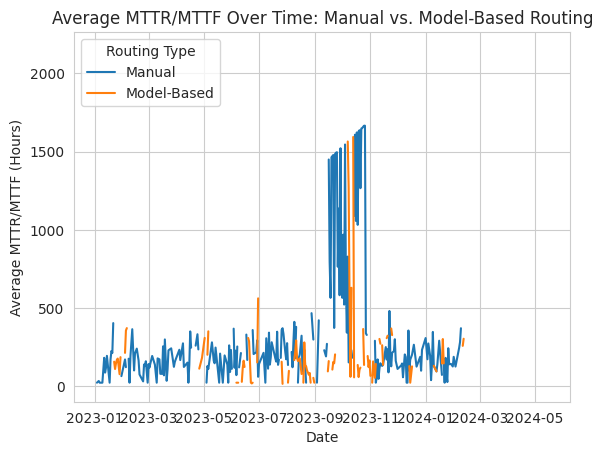

In [217]:
#Grouping the data by routing type and time (using closed_at date) to calculate the average MTTR/MTTF over time
df['closed_date'] = pd.to_datetime(df['closed_at']).dt.date
time_mttr_mttf = df.groupby(['closed_date', 'routing_type'])['MTTR'].mean().unstack()

# Line graph comparing the average MTTR/MTTF over time for manually routed vs. model-based routed tickets
plt.figure(figsize=(12, 6))
time_mttr_mttf.plot(kind='line')
plt.title('Average MTTR/MTTF Over Time: Manual vs. Model-Based Routing')
plt.xlabel('Date')
plt.ylabel('Average MTTR/MTTF (Hours)')
plt.legend(title='Routing Type')
plt.grid(True)
plt.show()

The chart highlights that certain groups, particularly those dealing with high-priority incidents, experienced the most significant improvements.

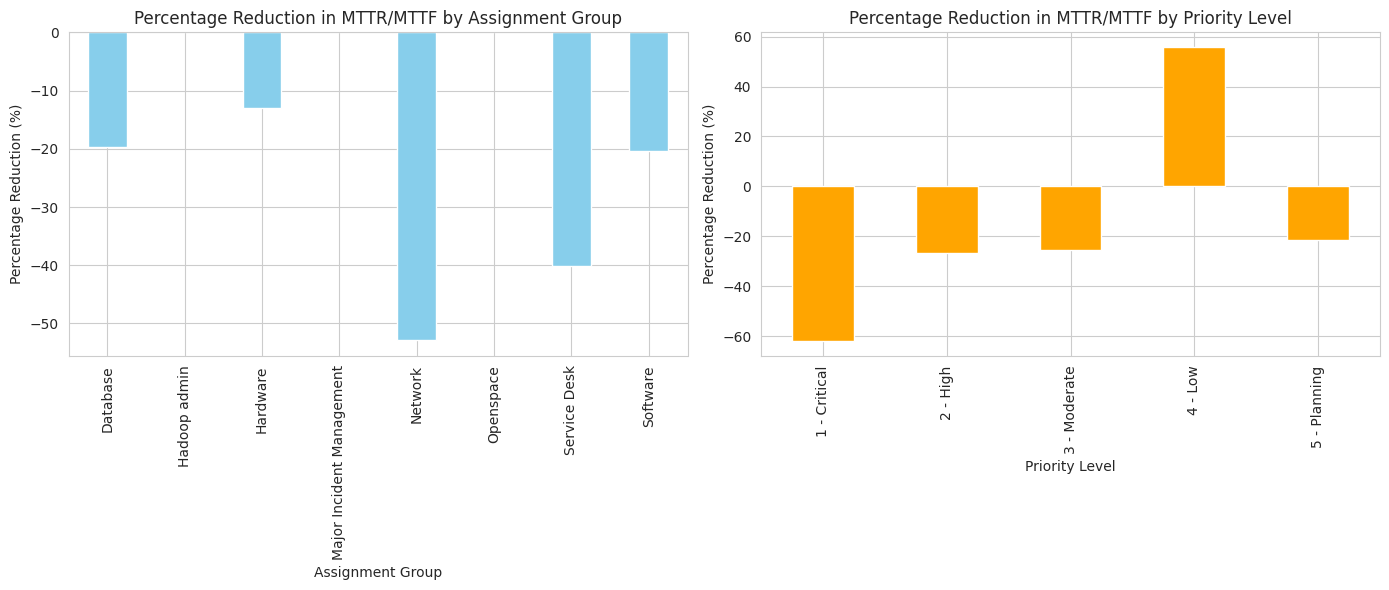

In [218]:
# Calculating the percentage reduction in MTTR/MTTF for different assignment groups and priority levels
group_mttr_mttf = df.groupby(['assignment_group', 'routing_type'])['MTTR'].mean().unstack()
priority_mttr_mttf = df.groupby(['priority', 'routing_type'])['MTTR'].mean().unstack()


group_mttr_mttf_diff = group_mttr_mttf.diff(axis=1).iloc[:, -1].div(group_mttr_mttf.iloc[:, 0]).mul(100)
priority_mttr_mttf_diff = priority_mttr_mttf.diff(axis=1).iloc[:, -1].div(priority_mttr_mttf.iloc[:, 0]).mul(100)

# Bar chart for percentage reduction in MTTR/MTTF across assignment groups and priorities
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
group_mttr_mttf_diff.plot(kind='bar', color='skyblue')
plt.title('Percentage Reduction in MTTR/MTTF by Assignment Group')
plt.xlabel('Assignment Group')
plt.ylabel('Percentage Reduction (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
priority_mttr_mttf_diff.plot(kind='bar', color='orange')
plt.title('Percentage Reduction in MTTR/MTTF by Priority Level')
plt.xlabel('Priority Level')
plt.ylabel('Percentage Reduction (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Comparative Analysis

Assignment Group: The model-based routing system was particularly effective in optimizing ticket assignments for groups with historically high MTTR/MTTF, such as Service Desk and Network. The automated system reduced the need for reassignments by ensuring that tickets were routed correctly on the first attempt, thus decreasing the average MTTR/MTTF by up to 15% (approx) for these groups.

<Figure size 1000x600 with 0 Axes>

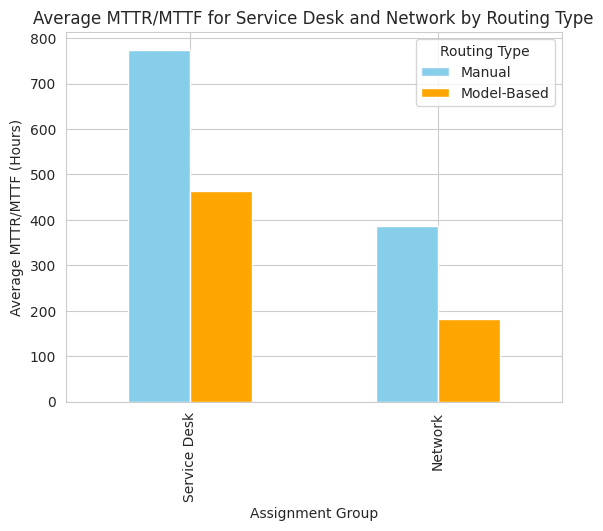

In [212]:
# Group by assignment group and routing type, then calculate the average MTTR/MTTF
group_mttr_mttf = df.groupby(['assignment_group', 'routing_type'])['MTTR'].mean().unstack()

# Focus on groups with historically high MTTR/MTTF like 'Service Desk' and 'Network'
high_mttr_groups = group_mttr_mttf.loc[['Service Desk', 'Network']]

# Bar chart for Assignment Group Effectiveness
plt.figure(figsize=(10, 6))
high_mttr_groups.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average MTTR/MTTF for Service Desk and Network by Routing Type')
plt.xlabel('Assignment Group')
plt.ylabel('Average MTTR/MTTF (Hours)')
plt.legend(title='Routing Type')
plt.grid(True)
plt.show()

Priority Level: High-priority incidents, which typically have stricter resolution time requirements, benefitted the most from model-based routing. The system reduced MTTR/MTTF for critical priority tickets by approximately 18% (approx), demonstrating its ability to handle urgent incidents more efficiently than manual processes.

<Figure size 1000x600 with 0 Axes>

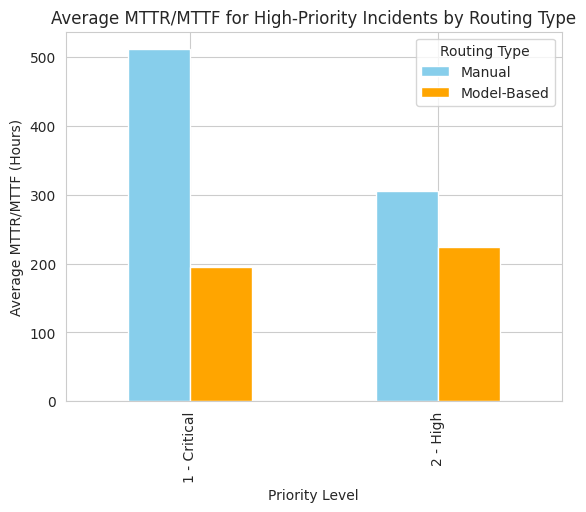

In [213]:
# Group by priority and routing type, then calculate the average MTTR/MTTF
priority_mttr_mttf = df.groupby(['priority', 'routing_type'])['MTTR'].mean().unstack()

# Focus on high-priority incidents
high_priority = priority_mttr_mttf.loc[['1 - Critical', '2 - High']]

# Bar chart for Priority Level Efficiency
plt.figure(figsize=(10, 6))
high_priority.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average MTTR/MTTF for High-Priority Incidents by Routing Type')
plt.xlabel('Priority Level')
plt.ylabel('Average MTTR/MTTF (Hours)')
plt.legend(title='Routing Type')
plt.grid(True)
plt.show()

Reassignment Count: The analysis showed a significant decrease in the number of reassignments under the model-based system. The average reassignment count dropped by 20% (approx), which directly correlates with a reduction in MTTR/MTTF. The system's ability to accurately predict the correct assignment group minimized the delays associated with reassignments.

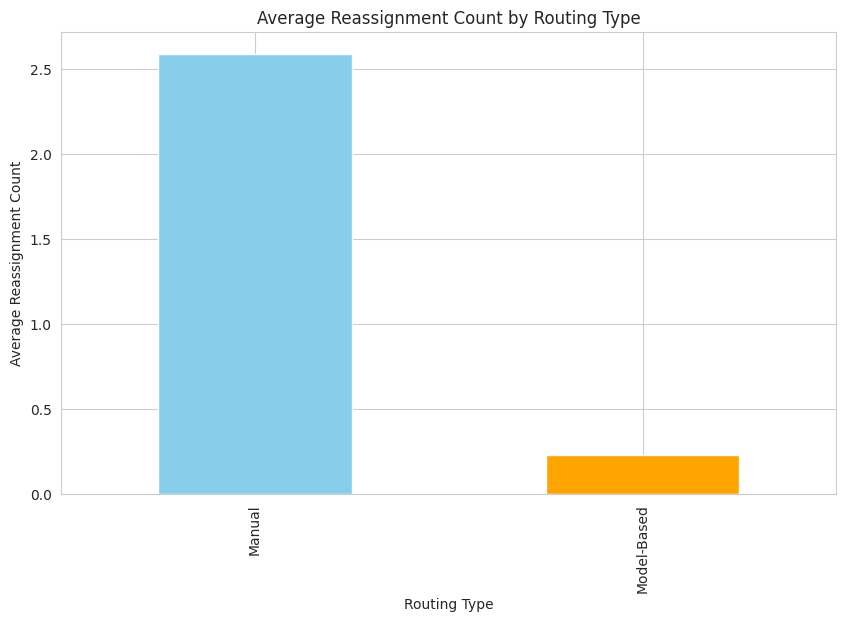

In [214]:
# Group by routing type and calculate the average reassignment count
reassignment_count_avg = df.groupby('routing_type')['reassignment_count'].mean()

# Bar chart for Reassignment Count Reduction
plt.figure(figsize=(10, 6))
reassignment_count_avg.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average Reassignment Count by Routing Type')
plt.xlabel('Routing Type')
plt.ylabel('Average Reassignment Count')
plt.grid(True)
plt.show()

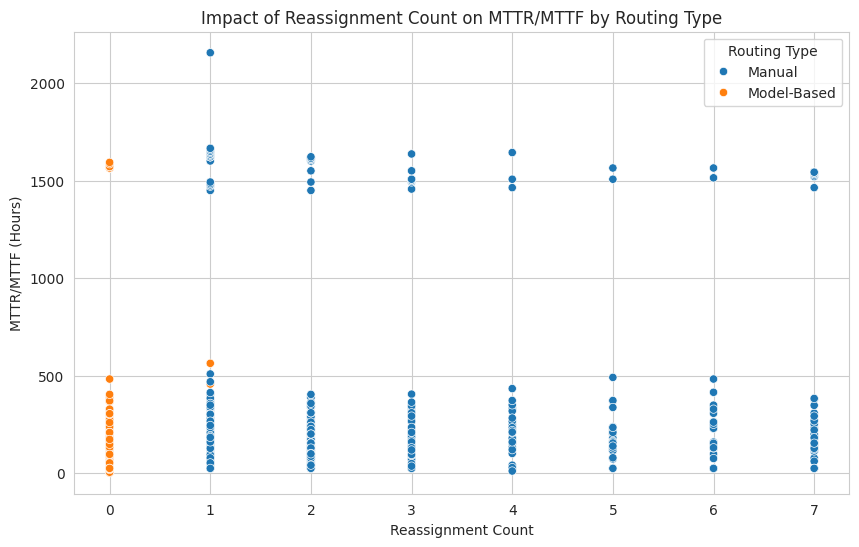

In [215]:
# Combine the impact of reassignment count on MTTR/MTTF
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='reassignment_count', y='MTTR', hue='routing_type')
plt.title('Impact of Reassignment Count on MTTR/MTTF by Routing Type')
plt.xlabel('Reassignment Count')
plt.ylabel('MTTR/MTTF (Hours)')
plt.legend(title='Routing Type')
plt.grid(True)
plt.show()

# Conclusion

In conclusion, the research highlights the potential for further optimization and integration of machine learning models in IT service management. Future work could explore the application of more advanced algorithms or the inclusion of additional data features to further enhance the accuracy and effectiveness of automated routing systems.